<a href="https://colab.research.google.com/github/morarumd/ml-training/blob/master/Digit_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import google.colab.drive as drive
from google.colab import output
import matplotlib.pyplot as plt
import scipy.io as scipyio
import pandas as pd
import torchvision
import numpy as np
import zipfile
import random
import torch
import h5py 
import os

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Config

In [28]:
img_size = 224  # 14 * 16
grid_size = 16
cell_size = img_size // grid_size
ecoding_array_size = 15
confidence_threshold = .5

mean = np.array([0.485, 0.456, 0.406]).astype(np.float32).reshape(1, -1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).astype(np.float32).reshape(1, -1, 1, 1)

# Helper Functions

In [29]:
drive_path = '/gdrive/My Drive/digit_detection'
data_path = '/content/data'
font = ImageFont.truetype(f'{drive_path}/arial.ttf', size=15)

if not os.path.isdir(data_path):
    train_zipfile = zipfile.ZipFile(f'{drive_path}/train.zip', mode='r')
    train_zipfile.extractall(path=data_path)
    test_zipfile = zipfile.ZipFile(f'{drive_path}/test.zip', mode='r')
    test_zipfile.extractall(path=data_path)

def annotate_img(img, y_hat):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    for cy in range(y_hat.shape[0]):
        for cx in range(y_hat.shape[1]):
            y_ = y_hat[cy, cx]
            c, y, x, h, w, lb = y_[0], y_[1], y_[2], y_[3], y_[4], np.argmax(y_[5:])
            h, w = h * img_size, w * img_size
            y, x = (cy + y) * cell_size - h / 2, (cx + x) * cell_size - w / 2
            if c > confidence_threshold:
                draw.rectangle((x, y, x + w, y + h), outline='red')
                for i in [-1, 0, 1]:
                    for j in [-1, 0, 1]:
                        draw.text((x+i + 3, y+j+5), str(lb), fill='white', font=font)
                draw.text((x+3, y+5), str(lb), fill='black', font=font)
    return img

def batch_generator(dataset, batch_size=64):
    mat = h5py.File(f'{data_path}/{dataset}/digitStruct.mat', mode='r')
    dataset_size = mat['digitStruct/name'].shape[0]

    def read_ref(ref):
        if type(ref) is h5py.h5r.Reference:
            return mat[ref][()]
        return ref

    def read_item(idx):
        file_name = read_ref(mat['digitStruct/name'][()].flatten()[idx])
        file_name = ''.join(chr(x) for x in file_name.flatten())
        bboxes = mat[mat['digitStruct/bbox'][()].flatten()[idx]]

        img = Image.open(f'{data_path}/{dataset}/{file_name}')
        scale = min(img_size / img.size[0], img_size / img.size[1])
        img = img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))
        
        data = [bboxes[x][()].flatten() for x in ('top', 'left', 'height', 'width', 'label')]
        data = [[read_ref(x)[()].flatten()[0] for x in d] for d in data]
        tops, lefts, heights, widths = [(np.array(x) * scale).astype(np.int) for x in data[:4]]
        labels = np.array(data[-1]).astype(np.int)

        bg = Image.new('RGB', (img_size, img_size))
        min_y, min_x, max_y, max_x = np.min(tops), np.min(lefts), np.max(tops + heights), np.max(lefts + widths)

        offset_y = int((img_size - max_y + min_y) * random.random()) - min_y
        offset_x = int((img_size - max_x + min_x) * random.random()) - min_x
        bg.paste(img, (offset_x, offset_y))
        tops, lefts = tops + offset_y, lefts + offset_x
        y_hat = np.zeros((grid_size, grid_size, ecoding_array_size), dtype=np.float32)
        for t, l, h, w, lb in zip(tops, lefts, heights, widths, labels):
            y, x = t + h / 2, l + w / 2
            cy, cx = int(y / cell_size), int(x / cell_size)
            y, x = y / cell_size - cy, x / cell_size - cx
            h, w = h / img_size, w / img_size
            y_ = y_hat[cy, cx]
            y_[0], y_[1], y_[2], y_[3], y_[4], y_[5:][lb % 10] = 1, y, x, h, w, 1

        return bg, y_hat
    
    indexes = np.arange(dataset_size)
    np.random.shuffle(indexes)
    indexes = indexes[:(dataset_size // batch_size) * batch_size]
    indexes = indexes.reshape(-1, batch_size)

    for batch_index in indexes:
        yield [read_item(x) for x in batch_index]

def get_tensor_from_batch(batch):
    tensor = np.vstack([np.expand_dims(np.array(x[0]), 0) for x in batch]).transpose(0,3,1,2)
    tensor = (tensor.astype(np.float32) / 255 - mean) / std
    y_hat = np.vstack([np.expand_dims(np.array(x[-1]), 0) for x in batch])
    return torch.as_tensor(tensor).cuda(), torch.as_tensor(y_hat)


# Model and Loss

In [30]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Sequential(torch.nn.Linear(512, grid_size * grid_size * ecoding_array_size),
                               torch.nn.Sigmoid())

def compute_loss(y_pred, y_hat):
    conf_hat = y_hat[:, :, : , 0].view(-1)
    conf_pred = y_pred[:, :, : , 0].view(-1)
    loss_conf = conf_hat * torch.log(conf_pred)
    loss_conf += (1 - conf_hat) * torch.log(1 - conf_pred)
    loss_conf = -(torch.sum(loss_conf) / conf_hat.shape[0]) * .5

    bbox_yx_hat = y_hat[:, :, : , 1:3].view(-1, 2)
    bbox_yx_pred = y_pred[:, :, : , 1:3].view(-1, 2)
    bbox_hw_hat = torch.sqrt(y_hat[:, :, : , 3:5]).view(-1, 2)
    bbox_hw_pred = torch.sqrt(y_pred[:, :, : , 3:5]).view(-1, 2)
    loss_bbox = torch.sum(torch.square(bbox_yx_hat - bbox_yx_pred), dim=1)
    loss_bbox += torch.sum(torch.square(bbox_hw_hat - bbox_hw_pred), dim=1)
    loss_bbox = (torch.sum(loss_bbox * conf_hat) / conf_hat.shape[0]) * 5

    class_hat = y_hat[:, :, : , 5:].view(-1, 10)
    class_label = torch.argmax(class_hat, dim=1)   
    class_pred = y_pred[:, :, : , 5:].view(-1, 10)    
    loss_class = torch.nn.functional.cross_entropy(class_pred, class_label, reduction='none')
    loss_class = torch.mean(loss_class * conf_hat)
    # print(f'loss_conf: {loss_conf.item()}, loss_bbox: {loss_bbox.item()}, loss_class: {loss_class.item()}')
    return loss_conf + loss_bbox + loss_class

# One Sample Overfit

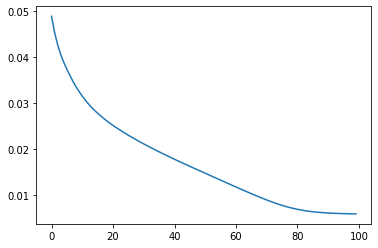

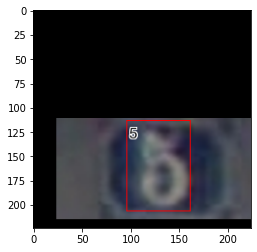

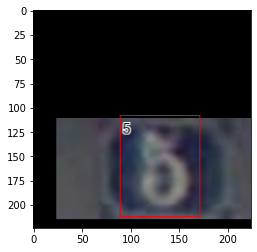

In [40]:
model.cuda().train()
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i, batch in enumerate(batch_generator('train', batch_size=1)):
    for _ in range(100):
        tensor, y_hat = get_tensor_from_batch(batch)
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            y_pred = model(tensor).view(-1, grid_size, grid_size, ecoding_array_size)
            loss = compute_loss(y_pred, y_hat.cuda())
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
    plt.plot(losses)
    plt.show()
    model.eval()
    y_p = model(tensor).view(-1, grid_size, grid_size, ecoding_array_size)[0].detach().cpu().numpy()
    plt.imshow(annotate_img(batch[0][0], y_hat[0].numpy())), plt.show()
    plt.imshow(annotate_img(batch[0][0], y_p)), plt.show()
    break


# Train

In [ ]:
model.cuda().train()
for lr in [1e-3, 1e-4, 1e-5]:
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i, batch in enumerate(batch_generator('train')):
        tensor, y_hat = get_tensor_from_batch(batch)
        # print(tensor.shape, y_hat.shape)
        # print(batch[0][0])
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            y_pred = model(tensor).view(-1, grid_size, grid_size, ecoding_array_size)
            loss = compute_loss(y_pred, y_hat.cuda())
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
    print(f'batch:{i}, loss:{losses[-1]}')
    plt.plot(losses)
    plt.show()


In [ ]:
model.eval()
for i, batch in enumerate(batch_generator('test')):
    tensor, y_hat = get_tensor_from_batch(batch)
    with torch.no_grad():
        y_pred = model(tensor).cpu().view(-1, grid_size, grid_size, ecoding_array_size).numpy()
    y_hat = y_hat.numpy()
    for item, y_h, y_p in zip(batch, y_hat, y_pred):
        print(y_p.shape)
        plt.imshow(annotate_img(item[0], y_h)), plt.show()
        plt.imshow(annotate_img(item[0], y_p)), plt.show()
        break
    break